In [1]:
import torch
import pandas as pd
import altair as alt
from torchviz import make_dot

# Abstracting our Code

Since we'll be stacking layers of arbitrary size arbitrarily deep, we might as well abstract away some of the code we need so we don't have to keep track of all the parameters in the model.

We'll first define a `LinearLayer` class that transforms a representation of size `h1` to one of size `h2`.

In [2]:
class LinearLayer():
    def __init__(self, h1, h2):
        self.W = torch.randn(h1,h2).requires_grad_()
        self.b = torch.randn(1,h2).requires_grad_()
    
    def __call__(self, x):
        return torch.matmul(x, self.W) + self.b
    
    def step(self, ϵ):
        with torch.no_grad():
            self.W -= ϵ * self.W.grad
            self.b -= ϵ * self.b.grad
            self.W.grad.zero_()        
            self.b.grad.zero_()

And now we can stack up as many of these as we want, of whatever sizes we want

In [3]:
from torch.nn.functional import relu

class Model():
    def __init__(self, sizes):
        self.layers = [LinearLayer(h1,h2) for h1, h2 in zip(sizes[:-1], sizes[1:])]
        self.activation = relu
    
    def __call__(self,x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)
    
    def step(self,ϵ):
        for layer in self.layers:
            layer.step(ϵ)

check it out:

In [4]:
n= 100
p = 1

x = torch.randn(n, p) # predictors (n observations, p features)
y = (x[:,0]**2).unsqueeze(dim=1) # outcomes (n observations)

my_model = Model([1,10,10,1])
L = torch.sum((y - my_model(x))**2)/n

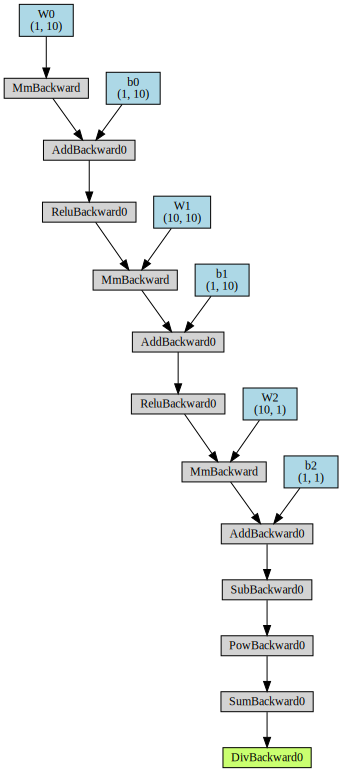

In [5]:
Ws = {f'W{k}':layer.W for k,layer in enumerate(my_model.layers)}
bs = {f'b{k}':layer.b for k,layer in enumerate(my_model.layers)}
make_dot(L, {**Ws, **bs})

In [6]:
n_steps = 1000
ϵ = 1*10e-4
loss_record = []

for e in range(n_steps):
    ŷ = my_model(x) 
    L = torch.sum((y-ŷ)**2)/len(ŷ)
    
    loss_record.append(L.item())
    L.backward()
    
    my_model.step(ϵ)

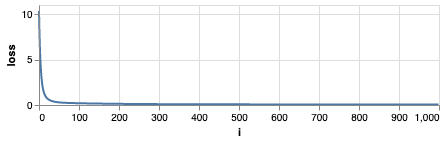

In [7]:
loss_df = pd.DataFrame({'i':range(n_steps), 'loss':loss_record})
alt.Chart(loss_df, height=100).mark_line().encode(x='i', y='loss')

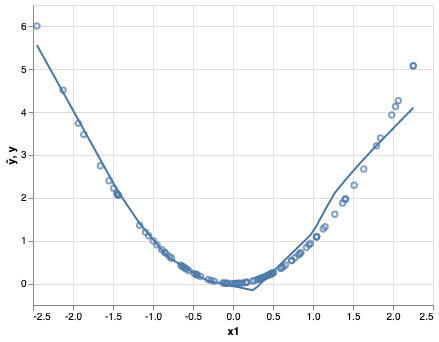

In [8]:
preds = pd.DataFrame({'ŷ':my_model(x).detach().numpy()[:,0], 'y':y[:,0], 'x1':x[:,0]})
(alt.Chart(preds).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

It's easy to get predictions on new data:

In [9]:
x_new = torch.randn(10, 1)
my_model(x_new)

tensor([[ 0.5051],
        [-0.1022],
        [ 0.2435],
        [ 0.0152],
        [ 0.3999],
        [ 0.6851],
        [ 2.2710],
        [ 0.8629],
        [ 0.2932],
        [ 0.0317]], grad_fn=<AddBackward0>)

Because our code is modular, it's trivial to add more layers or change their sizes. Let's also a new dataset with a different relationship between $x$ and $y$ to see we can fit pretty arbitrary nonlinearities.

In [10]:
x = torch.randn(n, p) # predictors (n observations, p features)
y = (x[:,0]**3 + torch.sin(4*x[:,0])).unsqueeze(dim=1) # outcomes (n observations)

In [11]:
my_model = Model([1,10,50,5,5,1])

n_steps = 2000
ϵ = 0.5*10e-4
loss_record = []

for e in range(n_steps):
    ŷ = my_model(x) 
    L = torch.sum((y-ŷ)**2)/len(ŷ)
    
    loss_record.append(L.item())
    L.backward()
    
    my_model.step(ϵ)

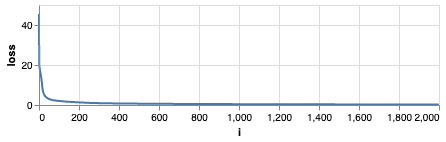

In [12]:
loss_df = pd.DataFrame({'i':range(n_steps), 'loss':loss_record})
alt.Chart(loss_df, height=100).mark_line().encode(x='i', y='loss')

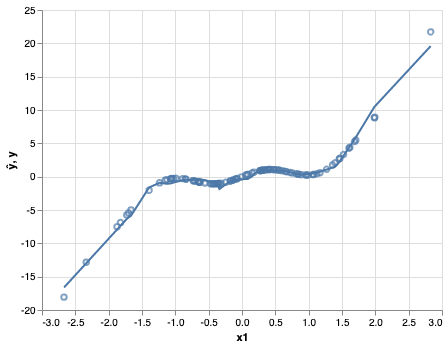

In [13]:
preds = pd.DataFrame({'ŷ':my_model(x).detach().numpy()[:,0], 'y':y[:,0], 'x1':x[:,0]})
(alt.Chart(preds).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

## Using pytorch's modules

Instead of implementing our own linear layer class, we can use the one that pytorch provides. We can also subclass `nn.Module` to make a model without having to define our own `step()` methods. All we need to do is define a `forward()` method that, given the input to the model, produces the output:

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model(nn.Module): # subclass nn.Module

    def __init__(self, sizes):
        super().__init__() # we need to initialize the nn.Module superclass for things to work
        self.layers = nn.ModuleList([nn.Linear(h1,h2) for h1, h2 in zip(sizes[:-1], sizes[1:])])
        self.activation = F.relu
    
    def forward(self,x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [15]:
my_model = Model([1,100,10,1]) # creates a model object with input size 1, two hidden layers of size 10, and an output of size 1
criterion = nn.MSELoss() # the loss function in torch is often named "criterion"
optimizer = optim.SGD(my_model.parameters(), lr=1*10e-4)

In [16]:
n_steps = 1000
loss_record = []

for e in range(n_steps):
    ŷ = my_model(x) 
    L = criterion(y,ŷ)
    
    optimizer.zero_grad()
    loss_record.append(L.item())
    L.backward()
    optimizer.step()

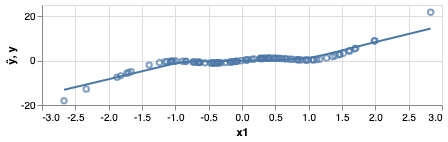

In [17]:
preds = pd.DataFrame({'ŷ':my_model(x).detach().numpy()[:,0], 'y':y[:,0], 'x1':x[:,0]})
(alt.Chart(preds, height=100).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

In [18]:
x_new = torch.randn(10, 1)
my_model(x_new) # predictions

tensor([[-4.7522],
        [ 0.4179],
        [ 0.0410],
        [-0.3007],
        [ 0.9673],
        [-7.1947],
        [ 0.9359],
        [ 0.3695],
        [ 0.6474],
        [ 9.3845]], grad_fn=<AddmmBackward>)


Pytorch has already implementing things like the ReLU and sigmoid functions, MSE, cross-entropy loss, linear layers, etc. So you don't have to worry about making errors implementing them yourself. Just figure out how to use their implementations and you're good to go. Don't worry too much about why you need to do specific things like `super().__init__()` when initializing a subclass of `nn.Module()`. As long as you understand *what* is happening under the hood, it doesn't really matter if you don't know exactly *how*. If you run into a problem where you need to figure it out, you will easily be able to if you need to do so.

We've been using pytorch so far to automate gradients, but now we've also seen that the `optim` module can be used to even automate the process of taking the gradient descent step. Basically, when you create an optimizer object like `optimizer = optim.SGD(my_model.parameters(), lr=1*10e-4)`, it associates with itself all of the model parameters that are accessible through `my_model.parameters()`. `parameters()` is a method that is available to `my_model` because you subclassed `nn.Module`, which ran through the internals of `my_model` to find all of the parameters associated with all of the layers. Now when you call `optimizer.step()` after populating all of the `param.grad` (which happens when you do `L.backward()`), the optimizer applies some algorithm to take all the gradients and change the values of the parameters accordingly. The simplest algorithm is the standard gradient descent we've been using, but many other enhancements are also available (see the [gradient descent primer](https://github.com/alejandroschuler/articles/blob/master/grad_descent/Gradient%20Descent.ipynb) to understand the details). For instance, adding momentum is easy:

In [19]:
my_model = Model([1,100,1]) 
criterion = nn.MSELoss() # the loss function in torch is often named "criterion"
optimizer = optim.SGD(my_model.parameters(), lr=1*10e-5, momentum=0.1)

In [20]:
n_steps = 5000
loss_record = []

for e in range(n_steps):
    ŷ = my_model(x) 
    L = criterion(y,ŷ)
    
    optimizer.zero_grad()
    loss_record.append(L.item())
    L.backward()
    optimizer.step()

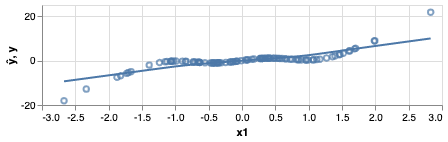

In [21]:
preds = pd.DataFrame({'ŷ':my_model(x).detach().numpy()[:,0], 'y':y[:,0], 'x1':x[:,0]})
(alt.Chart(preds, height=100).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

Notice we didn't have to change the training loop at all- we just passed an extra parameter to the optimizer. We can also make more radical changes to the optimizer (in this case we'll use the [ADAM algorithm](https://ruder.io/optimizing-gradient-descent/index.html#adam), another form of gradient descent):

In [22]:
my_model = Model([1,100,1]) 
criterion = nn.MSELoss() # the loss function in torch is often named "criterion"
optimizer = optim.Adam(my_model.parameters(), lr=1*10e-5)

In [23]:
n_steps = 5000
loss_record = []

for e in range(n_steps):
    ŷ = my_model(x) 
    L = criterion(y,ŷ)
    
    optimizer.zero_grad()
    loss_record.append(L.item())
    L.backward()
    optimizer.step()

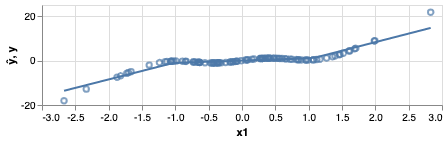

In [24]:
preds = pd.DataFrame({'ŷ':my_model(x).detach().numpy()[:,0], 'y':y[:,0], 'x1':x[:,0]})
(alt.Chart(preds, height=100).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

## Minibatching and Dataloaders

So far we've been using all of the data to calculate the gradients in each gradient descent step. However, doing that requires us to have all of the data in-memory at each step to look at $y_i$ and calculate $\hat y_i$ for every single $i$. Mini-batch stochastic gradient descent avoids this problem: in each iteration, we only use a subset of the data (a *batch* or *minibatch*) to calculate the loss, and consequently the gradients. It turns out that doing this also helps the optimization algorithm get out of local minima, so it's a win-win (more details in the [gradient descent primer](https://github.com/alejandroschuler/articles/blob/master/grad_descent/Gradient%20Descent.ipynb) and [overview of gradient descent methods](https://ruder.io/optimizing-gradient-descent/index.html#minibatchgradientdescent)).

In practice, people *always* use batching when training neural networks, so pytorch makes it easy to do so:

In [25]:
from torch.utils.data import DataLoader
trainloader = DataLoader(list(zip(x,y)), batch_size=20, shuffle=True)

In [26]:
my_model = Model([1,100,10,1]) 
criterion = nn.MSELoss() # the loss function in torch is often named "criterion"
optimizer = optim.Adam(my_model.parameters(), lr=1*10e-5)

`DataLoader` splits the provided data into batches. We iterate through each batch, updating the paramters with a gradient descent step each time. Once we've looked at each batch once (i.e. we've gone through the full datasets once), we call that an *epoch* and start again.

In [27]:
n_epochs = 1000
loss_record = []

for e in range(n_epochs):
    for x_batch, y_batch in trainloader:
        ŷ_batch = my_model(x_batch) 
        
        optimizer.zero_grad()
        L = criterion(y_batch, ŷ_batch)
        L.backward()
        optimizer.step()
    full_loss = criterion(y, my_model(x))
    loss_record.append(full_loss.item())

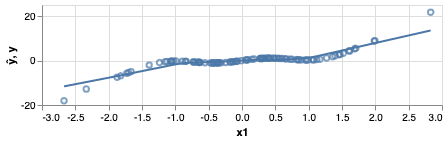

In [28]:
preds = pd.DataFrame({'ŷ':my_model(x).detach().numpy()[:,0], 'y':y[:,0], 'x1':x[:,0]})
(alt.Chart(preds, height=100).mark_line().encode(x='x1', y='ŷ') + 
alt.Chart(preds).mark_point().encode(x='x1', y='y'))

## Final Exercises

## Regression

Let's use everything we know to build some models. The first dataset we'll use is data on different wines.

To start with, we'll download and read in the data into a pandas dataframe.

In [29]:
import pandas as pd
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', delimiter=";")

Feel free to do any exploratory data analysis or investigate what's in the dataset using any tools you like. You'll see there are 11 predictors, all of which are numeric. There is one target (the "quality" of the wine), which we'll also treat as numeric.

Before building a model, I've turned the data into tensors and put it into a pytorch `DataLoader` for you

In [30]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X = data[[col for col in data.columns if col != 'quality']]
Y = data['quality']

# split into training and test sets, converting data frames to torch tensors along the way
X_train, X_test, Y_train, Y_test = [torch.tensor(data_frame.values).float() for data_frame in train_test_split(X, Y, test_size=0.33)]

# make a dataloader so we can iterate over batches
trainloader = DataLoader(list(zip(X_train,Y_train)), batch_size=50, shuffle=True)

Feel free to play around with the code above to figure out what it's doing. I didn't normalize the features or outcome, but if you wanted to, this would be the place to do it.

----
**EXERCISE** 

Use pytorch to write a 3-layer neural network class (call it `WineNet`), with ReLU activations in between layers 1 and 2 and between 2 and 3. The output of the 3rd layer will be your prediction. Expect an input to the first layer of size 11 (the number of predictors we have). The output sizes of the 1st and 2nd layers should be variables that the user can set when they instantiate the class, like `model = WineNet(100, 50)`. The 3rd layer should have an ouput of size 1, since it's $\hat y$.
    
To test your model, initialize it with some sizes of hidden layers (say, 100, 50), and run the training predictors through it and see what output you get. The predictions will be garbage since the model is untrained, but you can see if it all goes smoothly and your model is ready for training.
    
Use the pytorch `Adam` optimizer with 1e-5 learning rate to fit your model to the wine data (using the provided `trainloader`) by minimizing the mean-squared-error loss with your model, using 100 and 50 as the hidden layer sizes. Write a training loop to fit your model for 100 epochs. Record the value of the training loss at the end of each epoch.
    
Make a plot of the epoch (x-axis) vs. training loss (y-axis). Calculate the model's predictions on the test set and use the predictions to calculate the mean-squared error on the test set.

---

## Classification

Now let's build a model for a binary outcome. The predictors in this dataset are characteristics of various patients along with information extracted from potential tumors. For each patient, the outcome is whether the tumor was benign or malignant. 

In [31]:
from sklearn.datasets import load_breast_cancer
X, Y = load_breast_cancer(True)

----
**EXERCISE**

Split these data into a training (70%) and test set (30%), convert all the data to torch tensors, and make a training dataloader.
    
Use pytorch to write a neural network class (call it `BCNet`) with any architechture (configuration of layers and activations) you like. As we did in our logistic regression example, we need to make sure there is a sigmoid function after the last linear layer to ensure that the predictions that come out of the model are probabilities. Use any loss function or optimizer that you think are reasonable. Fit your model.
    
Calculate the model's predictions (probabilities) on the test set. Use 0.5 as a threshold to binarize the probabilities into 'predicted malignant' and 'predicted benign' categories. For what proportion of the patients in the test set is your prediction correct (this is the *accuracy* metric)? Among those who were really malignant, how many did your model actually predict were malignant (this is the *recall* or *sensitivity*)? Among those who your model predicted were malignant, how many actually were malignant (this is the *precision*)?

Make changes to your architechture, training loss, and/or optimizer. How do your results change? See if there are changes you can make that consistently improve your performance in one or all of these metrics.

---